# Working with anisotropic materials

In [1]:
import numpy as np
import PyMoosh as PM
import PyMoosh.anisotropic as ani
from numpy import linalg as la_np


['/home/denis/Documents/git/PyMoosh/notebooks/In-depth_examples', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/denis/.local/lib/python3.10/site-packages', '/home/denis/Documents/git/PyMoosh', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/denis/.ipython']


/home/denis/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Defining variables

In [2]:
wl_nm = 640
thickness_nm = 100

theta_in_rad = np.pi/4 # Incidence angle

An anisotropic material is either defined by a list of optical indices (the different axes) or by a link to the RefractiveIndex Database (see `How_materials_work`).

Its position in the structure is now defined by a rotation angle around a given rotation axis.
By default,
- `z` is the propagation axis (normal to the interfaces)
- `x` is the axis so that (xOz) is the plane of incidence
- `y` is the invariance axis

In [3]:

perm_1 = 1.2

perm_2 = 2.2


opt_ind = [perm_1, perm_2, perm_2] # biaxial material

mat_1=ani.AniMaterial(opt_ind, specialType="ANI")

mat_2=PM.Material(1.0) # regular, Isotropic material (vacuum / air)

# Lists!
material_list = [mat_1, mat_2] # The materials
stack = [1, 0, 0, 1] # Which material when (as in the usual Structure function)
thickness = [0, thickness_nm, 25, 0] # The thickness of each layer (as in the usual Structure function)
ani_rot_angle = [0., 0.5,-0.2, 0.] # The rotation angle for each layer. MUST be provided for isotropic layers too, will simply be overlooked
ani_rot_axis = ['z', 'x', 'y', 'z']  # The rotation axis for each layer. MUST be provided for isotropic layers too, will simply be overlooked


structure1 = ani.AniStructure(material_list, stack, thickness, ani_rot_angle, ani_rot_axis, verbose=False)


Computations are easy!

`coefficients_ani` returns: `tpp`,`tps`,`tsp`,`tss`,`rpp`,`rps`,`rsp`,`rss`, in this order

In [4]:

thetas = np.linspace(0,80,80)*np.pi/180
l_rpp = []
l_rps = []
l_rsp = []
l_rss = []
l_tpp = []
l_tps = []
l_tsp = []
l_tss = []


for theta_in_rad in thetas:
    res = ani.coefficients_ani(structure1, wl_nm, theta_in_rad)
    l_tpp.append(res[0])
    l_tps.append(res[1])
    l_tsp.append(res[2])
    l_tss.append(res[3])
    l_rpp.append(res[4])
    l_rps.append(res[5])
    l_rsp.append(res[6])
    l_rss.append(res[7])


Plotting results

/home/denis/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/denis/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


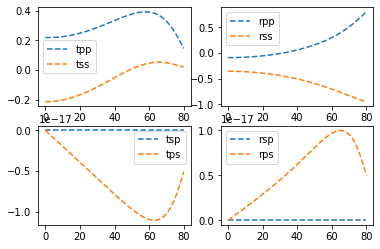

In [5]:

import matplotlib.pyplot as plt
plt.subplot(2,2,1)
plt.plot(thetas*180/np.pi, l_tpp, label='tpp', linestyle='--')
plt.plot(thetas*180/np.pi, l_tss, label='tss', linestyle='--')
plt.legend()

plt.subplot(2,2,2)
plt.plot(thetas*180/np.pi, l_rpp, label='rpp', linestyle='--')
plt.plot(thetas*180/np.pi, l_rss, label='rss', linestyle='--')
plt.legend()

plt.subplot(2,2,3)
plt.plot(thetas*180/np.pi, l_tsp, label='tsp', linestyle='--')
plt.plot(thetas*180/np.pi, l_tps, label='tps', linestyle='--')
plt.legend()

plt.subplot(2,2,4)
plt.plot(thetas*180/np.pi, l_rsp, label='rsp', linestyle='--')
plt.plot(thetas*180/np.pi, l_rps, label='rps', linestyle='--')
plt.legend()
plt.show()
